## Automating Technical Analysis & Systematic BackTesting of Trading Strategies with Python

In this article I will be using some awesome packages to show you how simple it is to get started with automating the generation of technical analysis features. I will then go on to use these features to generate some simple systematic trading strategies that I will then backtest. This is about the simplest workflow that I have seen for this. I hope you will be pleasantly surprised. 

### Techincal Analysis

Technical Analysis is the study of investments using prices, volumes and other derived data point histories. As a time-honoured discipline, over the years many indicators have been produced from all parts of the globe. Long the preserve of human eyeballs - the advent of computing in finance has changed the technical analysis landscape with a new level of rigour - leading to the emergence of Systematic Trading and Investment - now well established and the emergent field of AI-first finance - which could leverage such features for Machine Learning. The spread of Python has greatly democratised such pursuits - making them easier than ever to master.

**Sections**

[Get our data](#Data)

[Pandas TA](#PandasTA)

[Create Bollinger Bands](#BB)

[Implement Candlestick Pattern Recognition](#Candle)

[BackTrader Package](#BackTrader)

[Conclusion](#Conclusion)

**Pre-requisites:**

**LSEG Workspace** with access to [LSEG Data Library for Python](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python) (Free Trial Available)

Python 3.x

Required Python Packages: [LSEG Data Library for Python](https://pypi.org/project/lseg-data/), [pandas](https://pypi.org/project/pandas/), [numpy](https://pypi.org/project/numpy/), [matplotlib==](https://pypi.org/project/matplotlib/), [TA-Lib](https://pypi.org/project/TA-Lib/), [pandas_ta](https://pypi.org/project/pandas-ta/), [mplfinance](https://pypi.org/project/mplfinance/), [backtrader](https://pypi.org/project/mplfinance/)

### Import all the packages we need

In [1]:
import lseg.data as ld
import talib
import pandas_ta as pta
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplfinance as mpf
import datetime as dt
import numpy as np
import warnings

warnings.simplefilter("ignore")

%matplotlib inline
plt.style.use("dark_background")
mpl.style.use("dark_background")
ld.open_session(app_key='<APP KEY>')



<lseg.data.session.Definition object at 0x16c7792ab70 {name='workspace'}>

<a id='Data'></a>
### Get our data - one Line API call

Here we use our get_timeseries function to return us hourly OHLCV for cable (GBP=). As FX doesn't carry volume directly - we can use count as a surrogate. We then rename the columns so they can work with charting and backtesting software downstream. Note the dataframe comes back already indexed on timestamp. 

In [2]:
RIC = ['GBP=']
start_date = '2025-01-10'
end_date = '2025-06-27'

df1 = ld.get_history(
    universe=RIC,
    fields = ['OPEN_BID','BID_HIGH_1','BID_LOW_1','BID','BID_NUMMOV'],
    start = start_date,
    end = end_date,
    interval = '1h')

df1.columns=['open','high','low','close','volume']
df1

,open,high,low,close,volume
Timestamp,,,,,
2025-01-10 00:00:00,1.2298,1.2304,1.2291,1.2294,1696
2025-01-10 01:00:00,1.2295,1.2308,1.2292,1.2301,2270
2025-01-10 02:00:00,1.2302,1.2307,1.2297,1.2303,1807
2025-01-10 03:00:00,1.2303,1.2305,1.2297,1.2299,1483
2025-01-10 04:00:00,1.2299,1.2303,1.2288,1.2291,1622
...,...,...,...,...,...
2025-06-26 19:00:00,1.3746,1.3748,1.3725,1.3731,3499
2025-06-26 20:00:00,1.3732,1.3736,1.3719,1.3731,2160
2025-06-26 21:00:00,1.3727,1.3732,1.3719,1.3726,1794


In [3]:
df1.dropna(how="any", inplace=True)
len(df1)

2946

### Pandas TA package is very useful tool to create various technical analysis features with ease

### Types of Indicator

Cycles(1), Momentum(41), Overlap(33), Performance(3), Statistics(11), Trend(18), Utility(5), Volatility(14), Volume(15) as well as Candlestick Patterns (64) are provided by the package ready for you to implement - and as we will see implementation is a breeze. The breadth of indicators means that you can experiment to your hearts content with combinations of indicators etc. We can look at what these are as below:

In [4]:
df1.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

### Lets see how easy it is to create some Bollinger Bands

Here we will use a popular indicator in the volatility catergory - Bollinger Bands. First we will make a copy of our base price dataframe and then append the bollinger bands feature to the new dataframe. We pass some parameters such as window length of 50 periods, using an simple moving average. We can see the BBL (lower), BBM (mid) and BBU (upper) features, amongst others added to the right of the frame.

In [5]:
df2 = df1.copy()
df2.ta.bbands(length=50, std=2, mamode="sma", ddof=0, append=True)
df2

,open,high,low,close,volume,BBL_50_2.0,BBM_50_2.0,BBU_50_2.0,BBB_50_2.0,BBP_50_2.0
Timestamp,,,,,,,,,,
2025-01-10 00:00:00,1.2298,1.2304,1.2291,1.2294,1696,NaN,NaN,NaN,NaN,<NA>
2025-01-10 01:00:00,1.2295,1.2308,1.2292,1.2301,2270,NaN,NaN,NaN,NaN,<NA>
2025-01-10 02:00:00,1.2302,1.2307,1.2297,1.2303,1807,NaN,NaN,NaN,NaN,<NA>
2025-01-10 03:00:00,1.2303,1.2305,1.2297,1.2299,1483,NaN,NaN,NaN,NaN,<NA>
2025-01-10 04:00:00,1.2299,1.2303,1.2288,1.2291,1622,NaN,NaN,NaN,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...
2025-06-26 19:00:00,1.3746,1.3748,1.3725,1.3731,3499,1.356026,1.366618,1.377210,1.550155,0.805976
2025-06-26 20:00:00,1.3732,1.3736,1.3719,1.3731,2160,1.356131,1.366822,1.377513,1.564286,0.793625
2025-06-26 21:00:00,1.3727,1.3732,1.3719,1.3726,1794,1.356326,1.367038,1.377750,1.567228,0.759608


We can now easily plot these as one would in a WorkSpace chart - its not as polished as the WorkSpace chart - but this is for programmatic usage mainly as opposed to in-depth interactive detailed visualisation.

<Axes: xlabel='Timestamp'>

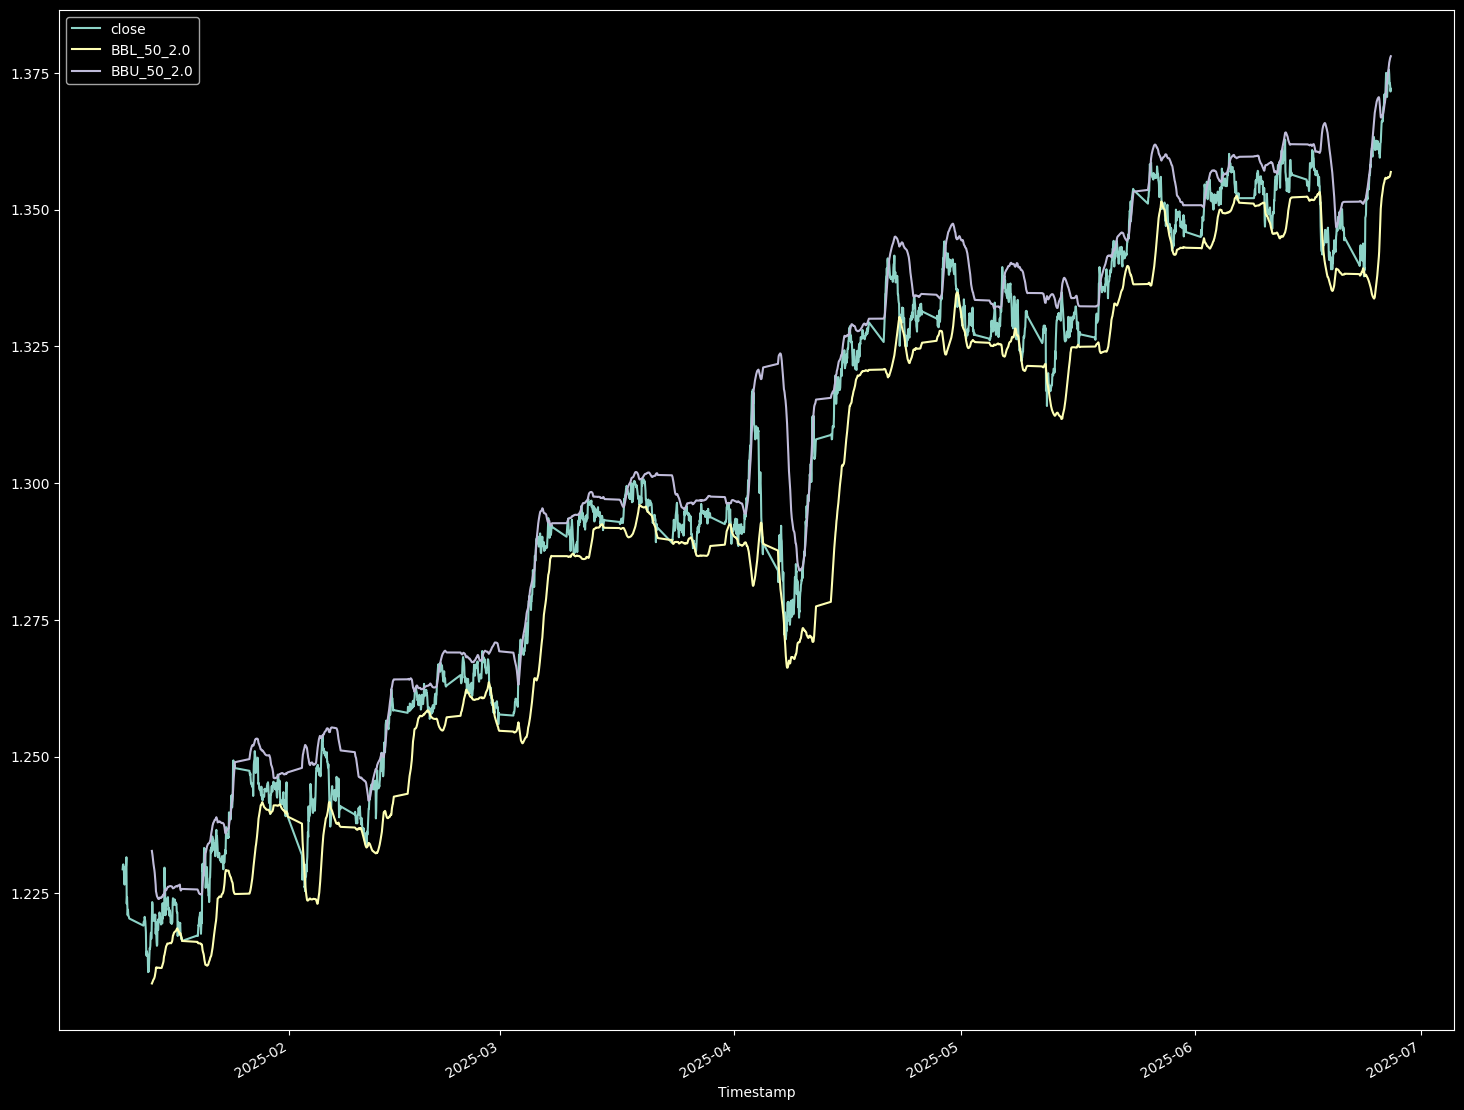

In [7]:
df2[['close','BBL_50_2.0','BBU_50_2.0']].plot(figsize=(18,15))

### Candlestick pattern recognition 

As we noted earlier there are 64 candlestick patterns that can be identified in both bullish and bearish configurations. Bullish structures are indicated with +100 and bearish structures are indicated with -100. In our case we are using hourly data so we are notified in the hourly row when the signal was generated. Again we simply make a copy of our original prices frame and then append all candlestick patters to that dataframe. One can of course select only the indicators you are interested in.

In [16]:
df3 = df1.copy()
df3.ta.cdl_pattern(name=["2crows", "3blackcrows", "3inside", 
                         "3linestrike", "3outside", "3starsinsouth", 
                         "3whitesoldiers", "abandonedbaby", "advanceblock", 
                         "belthold", "breakaway", "closingmarubozu", 
                         "concealbabyswall", "counterattack", "darkcloudcover"],append=True)
df3

,open,high,low,close,volume,CDL_2CROWS,CDL_3BLACKCROWS,CDL_3INSIDE,CDL_3LINESTRIKE,CDL_3OUTSIDE,CDL_3STARSINSOUTH,CDL_3WHITESOLDIERS,CDL_ABANDONEDBABY,CDL_ADVANCEBLOCK,CDL_BELTHOLD,CDL_BREAKAWAY,CDL_CLOSINGMARUBOZU,CDL_CONCEALBABYSWALL,CDL_COUNTERATTACK,CDL_DARKCLOUDCOVER
Timestamp,,,,,,,,,,,,,,,,,,,,
2025-01-10 00:00:00,1.2298,1.2304,1.2291,1.2294,1696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-10 01:00:00,1.2295,1.2308,1.2292,1.2301,2270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-10 02:00:00,1.2302,1.2307,1.2297,1.2303,1807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-10 03:00:00,1.2303,1.2305,1.2297,1.2299,1483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-10 04:00:00,1.2299,1.2303,1.2288,1.2291,1622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-26 19:00:00,1.3746,1.3748,1.3725,1.3731,3499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0
2025-06-26 20:00:00,1.3732,1.3736,1.3719,1.3731,2160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-26 21:00:00,1.3727,1.3732,1.3719,1.3726,1794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It can be a bit difficult to see when these signals are being generated from large dataframes - so you can check the min and max readings to see if any bullish or bearish signals are present.

In [17]:
df3.describe()

,open,high,low,close,volume,CDL_2CROWS,CDL_3BLACKCROWS,CDL_3INSIDE,CDL_3LINESTRIKE,CDL_3OUTSIDE,CDL_3STARSINSOUTH,CDL_3WHITESOLDIERS,CDL_ABANDONEDBABY,CDL_ADVANCEBLOCK,CDL_BELTHOLD,CDL_BREAKAWAY,CDL_CLOSINGMARUBOZU,CDL_CONCEALBABYSWALL,CDL_COUNTERATTACK,CDL_DARKCLOUDCOVER
count,2946.0,2946.0,2946.0,2946.0,2946.0,2946.0,2946.0,2946.000000,2946.000000,2946.000000,2946.0,2946.0,2946.0,2946.000000,2946.000000,2946.0,2946.000000,2946.0,2946.0,2946.000000
mean,1.299157,1.30027,1.298116,1.2992,3890.517651,0.0,0.0,0.135777,0.101833,-0.882553,0.0,0.0,0.0,-1.120163,0.135777,0.0,0.305499,0.0,0.0,-0.033944
std,0.043508,0.043482,0.043526,0.043514,1913.721285,0.0,0.0,8.642016,3.190044,17.459197,0.0,0.0,0.0,10.526117,29.018732,0.0,25.061724,0.0,0.0,1.842399
min,1.2105,1.2132,1.2097,1.2106,1.0,0.0,0.0,-100.000000,0.000000,-100.000000,0.0,0.0,0.0,-100.000000,-100.000000,0.0,-100.000000,0.0,0.0,-100.000000
25%,1.2607,1.2615,1.2598,1.2607,2507.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
50%,1.2965,1.2974,1.2957,1.2965,3883.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
75%,1.3377,1.338675,1.3367,1.337775,5125.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
max,1.3756,1.377,1.375,1.3756,12774.0,0.0,0.0,100.000000,100.000000,100.000000,0.0,0.0,0.0,0.000000,100.000000,0.0,100.000000,0.0,0.0,0.000000


### Lets use Matplotlib Finance package to create some candlestick charts with ease

We can use the candlestick charts to help us visualise when these candlestick patterns fire - first lets create a candlestick chart and then overlay a candlestick signal - in our case the CDL_3INSIDE (3 inside candles pattern - which is a compression signal which can present in both bullish (+100) and bearish (-100) variants.

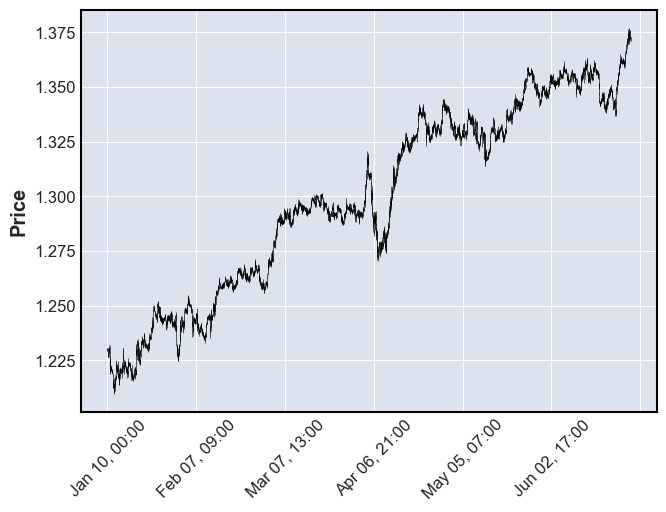

In [18]:
df3 = df3.astype(float)
mpf.plot(df3, type='candle')

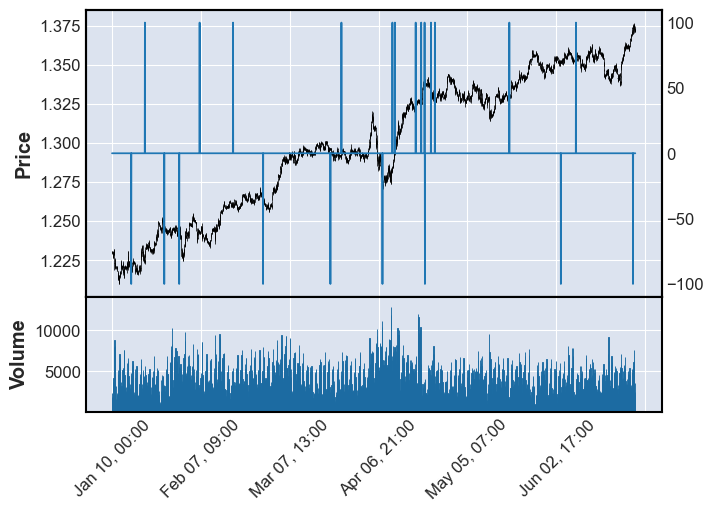

In [19]:
df3['volume'] = df3['volume'].astype(int)
apdict = mpf.make_addplot(df3['CDL_3INSIDE'])
mpf.plot(df3,volume=True,addplot=apdict)

### Implement backtesting of a strategy using BackTrader package

So we have seen how we can automate the creation of Techincal Analysis indicators very easily from a dataframe of prices. The ease with which we executed this is kind of remarkable. The next stage we can go to - is to use these indicators to create a trading strategy and to then test its efficacy through backtesting. This is also relatively easy to accomplish using the BackTrader package. First lets make a copy of our original dataframe.

In [20]:
df4 = df1.copy()

### Set up a simple SMA crossover strategy using built-in strategy

The BackTrader package uses a base strategy class which you can use to inherit from to build your own custom strategy. In our case we will be implementing 2 trading strategies firstly a simple moving average crossover (MA XOver) strategy and then a slightly more complex combinatorial strategy where we only take signals in the direction of the trend.

### smaCross strategy
First you can see this is composed of a list of parameter (in our case the window length for the moving averages). Next an init section which defines both the indicators from the bt.ind collection and also the crossover event itself. Note that the cross over event is bidirectional - though one can change this etc. Finally we have the trading logic section which uses the previously defined event signal (crossover signal) and combines it with our position information to inform an action. In our case we have defined to actions - 

* If we do not have a position and we have a bullish cross (ie fast sma crosses slow sma from below) then take a position
* If we do have a position and we have a bearish cross (ie fast sma crosses slow sma from above) then close the position

Note - we don't allow shorting in this first strategy for simplicities sake. We will include shorting in the second of our strategies.

In [21]:
class smaCross(bt.Strategy):
  # list of parameters which are configurable for the strategy
    params = dict(
        pfast=50,  # period for the fast moving average
        pslow=200   # period for the slow moving average
    )
    
    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal
  
    def next(self):
        if not self.position and self.crossover > 0:  # not in the market
            self.buy(size=100)
        elif self.position and self.crossover < 0:  # in the market & cross to the downside
            self.close()  # close long position

### Candle Mix Stategy

Here we extend our basic smaCross strategy by say introducing a candlestick pattern - in this case the 3Inside candlestick pattern. 

In [22]:
class cdlmix(bt.Strategy):
  # list of parameters which are configurable for the strategy
    params = dict(
        pfast=50,  # period for the fast moving average
        pslow=100   # period for the slow moving average
    )

    def __init__(self):
        self.cdl3 = bt.talib.CDL3INSIDE(self.data.open,self.data.high,self.data.low, self.data.close)
        self.sma1 = bt.ind.SMA(period=self.p.pfast)  # fast moving average
        self.sma2 = bt.ind.SMA(period=self.p.pslow)  # slow moving average
        self.crossover = bt.ind.CrossOver(self.sma1, self.sma2)  # crossover signal
  
    def next(self):
        if not self.position:
            if self.sma1 > self.sma2 and self.cdl3 == 100:  # not in the market
                self.buy(size=100)
            if self.sma1<self.sma2 and self.cdl3 == -100:
                self.sell(size=100)
        elif self.position.size > 0 and (self.crossover <0 or self.cdl3 == -100):  # in the market & cross to the downside
            self.close()  # close long position
            #self.sell(size=100) # Open short
        elif self.position.size < 0 and (self.crossover >0 or self.cdl3 == 100):  # in the market & cross to the downside
            self.close()  # close short position
            self.buy(size=100) # Open long

Now that we have our two strategies defined - we can pass it to our broker object which we configure to run the strategy we just created. From below we can see that the first section is where we initialise the bt.Cerebro object - setting our initial cash level and also commission rates. Next we add the strategy we just created and then define a data object which we wire up to our pandas dataframe, and specify the from and to dates as datetime objects and as we are using hourly bars we set the timeframe to be minutes with a compression rate of 60. We then add the data to the broker object and run the backtest and finally we format the standard chart output generated.

For easy multiple strategy tests - I have created a generalised brokerObject function from the basic package documentation which takes a number of parameters in order to create a valid backtest of a valid strategy and just configured it to return the cerebro.plot object which contains all the results. 

In [23]:
# create a function for this which takes a strategy_name, df, date_from, date_to & time_frame & compression as an input
def brokerObject(strategy_name,data_frame,from_date,to_date,time_frame,compression):
    
    # initialize backtrader broker
    cerebro = bt.Cerebro(stdstats=True)
    cerebro.broker.setcash(1000)
    cerebro.broker.setcommission(commission=0.001)

    # add strategy 
    cerebro.addstrategy(strategy_name)
    # wire up bt.feeds.PandasData to data_frame, set timeperiod, timeframe and also compression
    data = bt.feeds.PandasData(dataname=data_frame,fromdate=from_date,todate=to_date,
                               timeframe=time_frame,compression=compression) 
    cerebro.adddata(data)
        
    # run backtest
    res = cerebro.run()
    strat = res[0]

    #prepare plots
    mpl.rcParams['font.sans-serif']=['DejaVu Sans']
    mpl.rcParams['axes.unicode_minus']=False
    mpl.rcParams['figure.figsize']=[18, 16]
    mpl.rcParams['figure.dpi']=200
    mpl.rcParams['figure.facecolor']='w'
    mpl.rcParams['figure.edgecolor']='k'
    
    return cerebro.plot(style='candle',iplot=False,width=30,height=30,start=from_date, end=to_date)

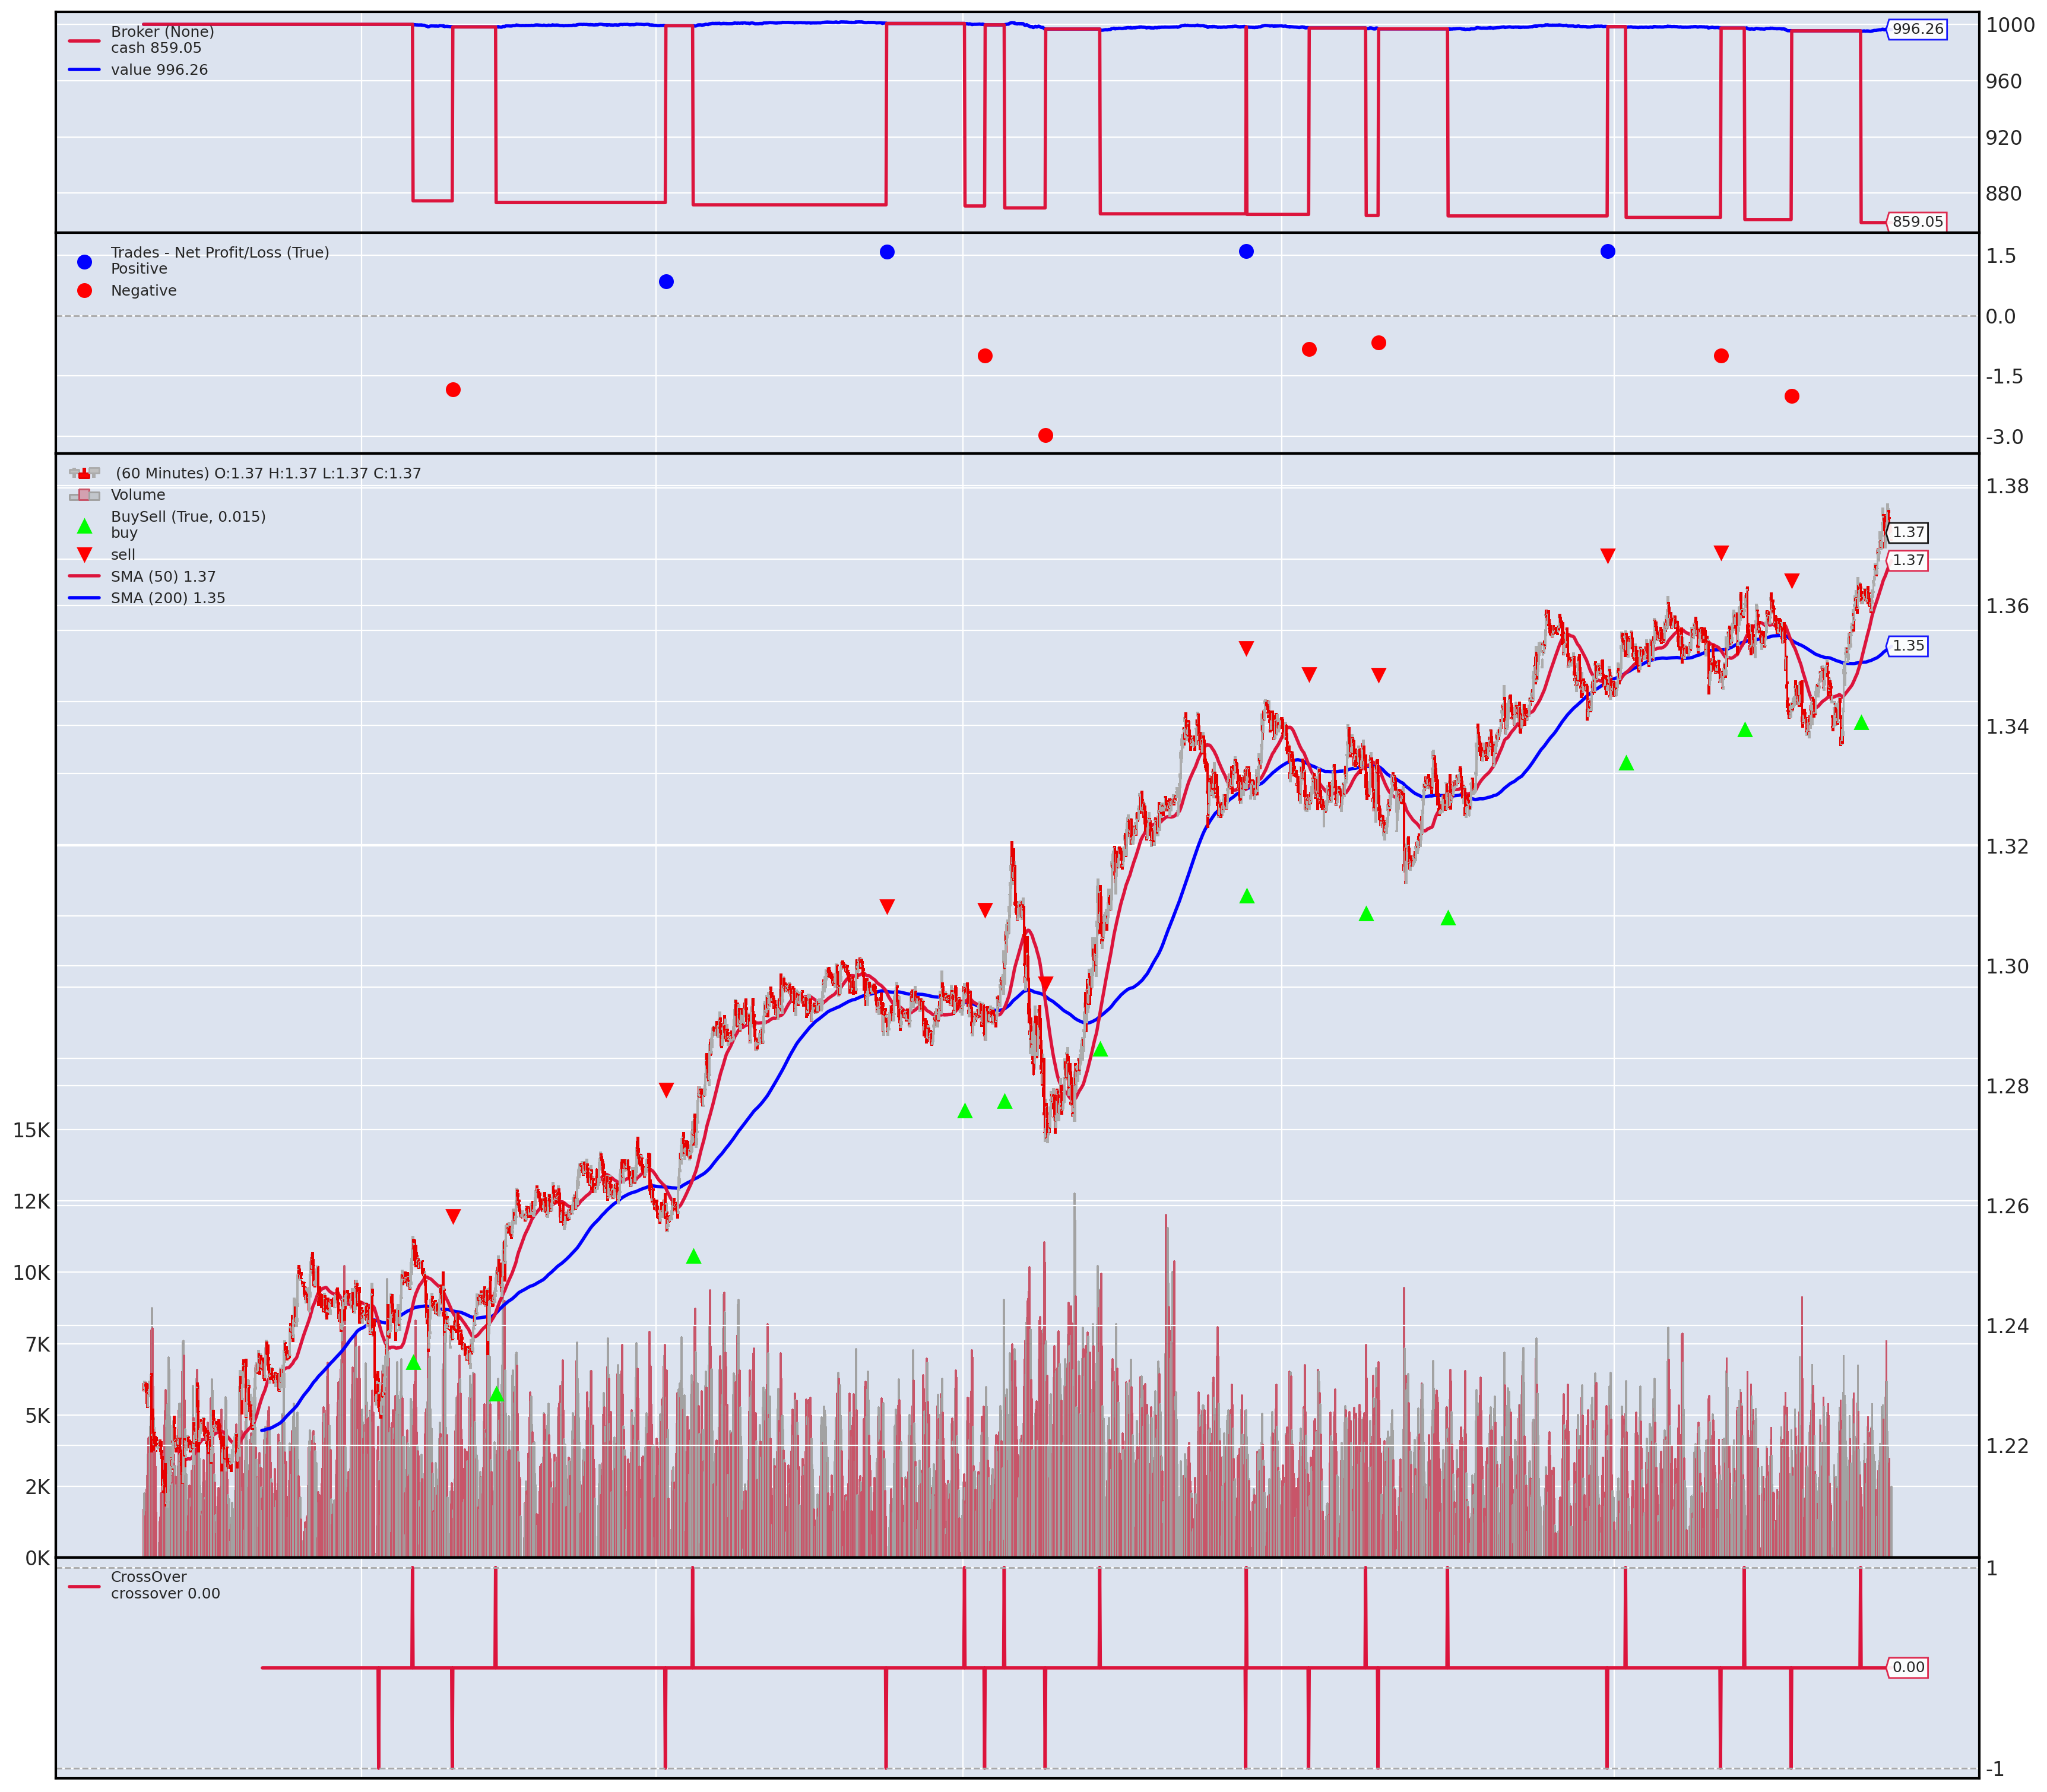

[[<Figure size 3600x3200 with 5 Axes>]]

In [24]:
brokerObject(smaCross,df4,dt.datetime.strptime(start_date, '%Y-%m-%d'),dt.datetime.strptime(end_date, '%Y-%m-%d'),bt.TimeFrame.Minutes,60)


Now we have our brokerObject function we can simply run another test just replacing the strategy with the new one...simples.

In [25]:
brokerObject(cdlmix,df4,dt.datetime.strptime(start_date, '%Y-%m-%d'),dt.datetime.strptime(end_date, '%Y-%m-%d'),bt.TimeFrame.Minutes,60)

[[<Figure size 3600x3200 with 5 Axes>]]

### Conclusion 

In this article we have seen how we can very easily generate Technical Analysis features using Pandas_TA / TA_Lib packages. These work seamlessly with the output from our LSEG Data Library and are simply appended to the right of the dataframe. We have also seen how we can eyeball these indicators using basic charting in Python. In particular we have shown how we can plot candlestick patterns firing on a chart with real simplicity. 

We then went on to take things a little further by creating some simple trading strategies using our indicators in the strategy template of the backtrader package and then wired that up to the backtrader broker object that conducted the backtest for us and outputted a series of plots that visualised the strategy and sig-gen, P&L and such. 

This is really the simplest workflow I have seen for backtesting trading strategies - and whilst there are undoubtably more sophisticated packages and approaches - particularly for live streaming strategies - I think this is a great introductory approach and worthy of your attention. 

## Further Resources

### [LSEG Developer Community](https://developers.lseg.com/en/)

* [Articles](https://developers.lseg.com/en/article-catalog) 
* [Use Cases](https://developers.lseg.com/en/use-cases-catalog)
* [Videos](https://developers.lseg.com/en/video-catalog)
* [APIs](https://developers.lseg.com/en/api-catalog?q1=devportal%3Acapability/recommended&x1=api_capabilities)
* [Q&A Forums](https://community.developers.refinitiv.com/)


For Content Navigation in Workspace - please use the Data Item Browser Application: Type 'DIB' into Search Bar.

### For Python/ AI/ML / Quant Finance / Algo Trading training

* [The Python Quants](https://home.tpq.io/)

    * Books:
    * [Python for Algorithmic Trading](https://www.oreilly.com/library/view/python-for-algorithmic/9781492053347/)
    * [Artifical Intelligence in Finance](https://www.oreilly.com/library/view/artificial-intelligence-in/9781492055426/)
    * [Python for Finance 2nd Ed.](https://www.oreilly.com/library/view/python-for-finance/9781492024323/)

### For Technical Analysis training & consultancy - Trevor Neil

* [The Beta Group](http://betagroup.co.uk/)

### Meetup Groups

* [Python Quants Meetup Group (Virtual/Live)](https://www.meetup.com/python-for-quant-finance-london/)
